In [30]:
# =============================================================================
# UNIVERSAL STIM DISCOVERY 
# =============================================================================

import os
import re
import mne
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET


datasets = {
    'bima_off': {
        'data_dir': "/home/jaizor/jaizor/xtra/data/PD_Bima",
        'filename_pattern': r"PD_(\d{3})_bima_DBSOFF\.mff"  
    },
    'rest_on': {
        'data_dir': "/home/jaizor/jaizor/xtra/data/PD_Rest/ON",
        'filename_pattern': r"PD_(\d{3})_rest_hand_foot_DBSON\.mff"
    },
    'rest_off': {
        'data_dir': "/home/jaizor/jaizor/xtra/data/PD_Rest/OFF",
        'filename_pattern': r"PD_(\d{3})_rest_hand_foot_DBSOFF\.mff"
    }}


# Define helper functions

def discover_stim_events(
    data_dir: str,
    filename_pattern: str,
    subject_format: str = "sub-{id:02d}",
    file_extension: str = ".mff") -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Discover stim channels and events in any dataset.
    """
    # Find subjects
    subjects = []
    compiled_pattern = re.compile(filename_pattern)
    for fname in os.listdir(data_dir):
        if not fname.endswith(file_extension):
            continue
        match = compiled_pattern.match(fname)
        if match:
            subj_num = int(match.group(1))
            subjects.append(subject_format.format(id=subj_num))
    
    if not subjects:
        print(f"⚠️ No files matching pattern found in {data_dir}")
        return pd.DataFrame(), pd.DataFrame()
    
    subjects = sorted(subjects, key=lambda x: int(re.search(r'\d+', x).group()))
    print(f"📁 Found {len(subjects)} subjects: {subjects}")
    
    # Helper functions
    def find_stim_channels(raw):
        stim_candidates = []
        for ch_name, ch_type in zip(raw.ch_names, raw.get_channel_types()):
            if ch_type in ['stim', 'misc']:
                stim_candidates.append(ch_name)
            elif any(kw in ch_name.upper() for kw in ['STI', 'TRIG', 'TTL']):
                stim_candidates.append(ch_name)
            elif ch_name[0].isdigit() and len(ch_name) <= 3:
                stim_candidates.append(ch_name)
        return sorted(set(stim_candidates))
    
    def extract_events(raw, stim_channels):
        events = []
        sfreq = raw.info['sfreq']
        for ch in stim_channels:
            if ch not in raw.ch_names:
                continue
            data = raw.get_data(picks=[ch])[0]
            digital = (data > 0.5).astype(int)
            diff = np.diff(digital, prepend=0)
            onset_samples = np.where(diff == 1)[0]
            onset_times = onset_samples / sfreq
            for t, s in zip(onset_times, onset_samples):
                events.append({
                    'subject': None,
                    'channel': ch,
                    'time_sec': t,
                    'sample': int(s),
                    'sfreq': sfreq
                })
        return pd.DataFrame(events) if events else pd.DataFrame()
    
    # Process subjects
    all_events_list = []
    subject_summaries = []
    
    for sub in tqdm(subjects, desc="Discovering Stim Events"):
        try:
            subj_num = int(re.search(r'\d+', sub).group())
            
            # Find matching file (more robust than reconstructing)
            matching_files = []
            for f in os.listdir(data_dir):
                if f.endswith(file_extension) and compiled_pattern.match(f):
                    if str(subj_num).zfill(3) in f:  # crude but effective
                        matching_files.append(f)
            
            if not matching_files:
                print(f"⚠️ No file found for {sub}")
                continue
                
            mff_path = os.path.join(data_dir, matching_files[0])
            raw = mne.io.read_raw_egi(mff_path, preload=True, verbose=False)
            
            stim_channels = find_stim_channels(raw)
            events_df = extract_events(raw, stim_channels)
            
            if not events_df.empty:
                events_df['subject'] = sub
                all_events_list.append(events_df)
            
            # Build summary
            summary = {
                'subject': sub,
                'duration_sec': raw.times[-1],
                'sfreq': raw.info['sfreq'],
                'stim_channels': ';'.join(stim_channels),
                'n_channels': len(stim_channels),
                'n_events': len(events_df)
            }
            
            if not events_df.empty:
                channel_counts = events_df['channel'].value_counts()
                for ch, count in channel_counts.items():
                    summary[f'events_{ch}'] = count
                summary['first_event'] = events_df['time_sec'].min()
                summary['last_event'] = events_df['time_sec'].max()
                if len(events_df) > 1:
                    gaps = np.diff(np.sort(events_df['time_sec']))
                    summary['min_gap'] = gaps.min()
                    summary['max_gap'] = gaps.max()
                    summary['median_gap'] = np.median(gaps)
                else:
                    summary.update({k: np.nan for k in ['min_gap', 'max_gap', 'median_gap']})
            else:
                summary.update({k: np.nan for k in ['first_event', 'last_event', 'min_gap', 'max_gap', 'median_gap']})
            
            subject_summaries.append(summary)
            print(f"✅ {sub}: {len(stim_channels)} channels, {len(events_df)} events")
            
        except Exception as e:
            print(f"❌ {sub}: {e}")
    
    all_events_df = pd.concat(all_events_list, ignore_index=True) if all_events_list else pd.DataFrame()
    summary_df = pd.DataFrame(subject_summaries) if subject_summaries else pd.DataFrame()
    
    return all_events_df, summary_df

def plot_stim_events(subject_id, events_df, figsize=(12, 4)):
    sub_events = events_df[events_df['subject'] == subject_id]
    
    if sub_events.empty:
        print(f"⚠️ No events found for {subject_id}")
        return
    
    plt.figure(figsize=figsize)
    for ch in sub_events['channel'].unique():
        ch_events = sub_events[sub_events['channel'] == ch]
        plt.scatter(ch_events['time_sec'], [ch] * len(ch_events), label=ch, alpha=0.7)
    
    plt.title(f"Stim Events for {subject_id}")
    plt.xlabel("Time (s)")
    plt.ylabel("Channel")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def clean_mff_events_with_namespace(
    mff_directory: str,
    trigger_code: str = 'TT140') -> str:
    """
    Clean EGI .mff XML events by removing events before first trigger occurrence.
    Properly handles XML namespaces.
    """
    namespace = {'ns': 'http://www.egi.com/event_mff'}
    
    # Find the Events XML file
    event_xml_path = os.path.join(mff_directory, "Events_ttl_event.xml")
    if not os.path.exists(event_xml_path):
        raise FileNotFoundError(f"Events_ttl_event.xml not found in {mff_directory}")
    
    print(f"✅ Found event file: Events_ttl_event.xml")
    
    # Parse the XML with namespace
    tree = ET.parse(event_xml_path)
    root = tree.getroot()
    
    # Find all events using namespace
    event_elements = root.findall('.//ns:event', namespace)
    
    # Extract event data
    events = []
    for event_elem in event_elements:
        code_elem = event_elem.find('ns:code', namespace)
        time_elem = event_elem.find('ns:relativeBeginTime', namespace)
        if code_elem is not None and time_elem is not None:
            events.append({
                'element': event_elem,
                'code': code_elem.text,
                'relative_time': int(time_elem.text),
                'time_seconds': int(time_elem.text) / 1_000_000
            })
    
    print(f"📋 Total events found: {len(events)}")
    
    # Check if trigger exists
    trigger_events = [e for e in events if e['code'] == trigger_code]
    if not trigger_events:
        raise ValueError(f"Trigger code '{trigger_code}' not found in events!")
    
    # Find first occurrence of trigger
    first_trigger_time = min(e['relative_time'] for e in events if e['code'] == trigger_code)
    first_trigger_seconds = first_trigger_time / 1_000_000
    
    print(f"⏱️ First '{trigger_code}' at {first_trigger_seconds:.3f}s (relative time: {first_trigger_time})")
    
    # Remove events before first trigger
    events_to_remove = [e for e in events if e['relative_time'] < first_trigger_time]
    
    print(f"🧹 Removing {len(events_to_remove)} events before first '{trigger_code}':")
    for event in events_to_remove[:10]:  # Show first 10
        print(f"   - {event['code']} at {event['time_seconds']:.3f}s")
    if len(events_to_remove) > 10:
        print(f"   ... and {len(events_to_remove)-10} more")
    
    # Remove from XML
    for event_data in events_to_remove:
        root.remove(event_data['element'])
    
    # Save cleaned XML
    cleaned_xml_path = event_xml_path.replace('.xml', '_cleaned.xml')
    tree.write(cleaned_xml_path, encoding='utf-8', xml_declaration=True)
    print(f"💾 Saved cleaned events to: {os.path.basename(cleaned_xml_path)}")
    
    return cleaned_xml_path


# Group events into trials

def get_trials_from_events(events_df):

    if events_df.empty:
        return pd.DataFrame(columns=[
            'subject', 'trial_number', 'start_time', 'end_time', 'duration_s', 'trial_name'
        ])
    
    result_rows = []
    
    for subject in events_df['subject'].unique():
        sub_df = events_df[events_df['subject'] == subject].copy()
        sub_df = sub_df.sort_values('time_sec').reset_index(drop=True)
        
        # Get first occurrence of each required marker
        try:
            c_time = sub_df[sub_df['channel'] == 'c']['time_sec'].iloc[0]
            o_time = sub_df[sub_df['channel'] == 'o']['time_sec'].iloc[0]
            onea_time = sub_df[sub_df['channel'] == '1a']['time_sec'].iloc[0]
            twoa_time = sub_df[sub_df['channel'] == '2a']['time_sec'].iloc[0]
        except IndexError:
            # Skip subject if any marker is missing
            continue
        
        # Get first 4 'x' events
        x_times = sub_df[sub_df['channel'] == 'x']['time_sec'].values
        if len(x_times) < 4:
            continue  # need at least 4 x's
        
        # Define trials in fixed order
        trials_config = [
            ('c', c_time, x_times[0]),
            ('o', o_time, x_times[1]),
            ('l', onea_time, x_times[2]),
            ('r', twoa_time, x_times[3])
        ]
        
        for trial_num, (name, start, end) in enumerate(trials_config, 1):
            if end <= start:
                # Skip if x is not after start (shouldn't happen, but safe)
                continue
            duration = end - start
            result_rows.append({
                'subject': subject,
                'trial_number': trial_num,
                'start_time': start,
                'end_time': end,
                'duration_s': duration,
                'trial_name': name
            })
    
    if not result_rows:
        return pd.DataFrame(columns=[
            'subject', 'trial_number', 'start_time', 'end_time', 'duration_s', 'trial_name'
        ])
    
    return pd.DataFrame(result_rows)[[
        'subject', 'trial_number', 'start_time', 'end_time', 'duration_s', 'trial_name'
    ]]
    

In [2]:
# =============================================================================
# EXECUTION
# =============================================================================

all_events, summary = discover_stim_events(
    data_dir="/home/jaizor/jaizor/xtra/data/PD_Rest/OFF",
    filename_pattern=r"PD_(\d{3})_rest_hand_foot_DBSOFF\.mff",
    subject_format="sub-{id:02d}"
)

📁 Found 12 subjects: ['sub-01', 'sub-02', 'sub-03', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-14']


Discovering Stim Events:   0%|          | 0/12 [00:00<?, ?it/s]

✅ sub-01: 288 channels, 34 events
✅ sub-02: 288 channels, 34 events
✅ sub-03: 288 channels, 34 events
✅ sub-05: 287 channels, 32 events
✅ sub-06: 288 channels, 34 events
✅ sub-07: 287 channels, 32 events
✅ sub-08: 287 channels, 32 events
✅ sub-09: 288 channels, 34 events
✅ sub-10: 287 channels, 32 events
✅ sub-11: 287 channels, 32 events
✅ sub-12: 288 channels, 34 events
✅ sub-14: 287 channels, 32 events


In [3]:
# Chek Columns
summary.columns

Index(['subject', 'duration_sec', 'sfreq', 'stim_channels', 'n_channels',
       'n_events', 'events_TT255', 'events_x', 'events_1a', 'events_2a',
       'events_3a', 'events_TT140', 'events_c', 'events_o', 'first_event',
       'last_event', 'min_gap', 'max_gap', 'median_gap'],
      dtype='object')

In [4]:
# Show full summary
summary[['subject', 'events_c', 'events_o', 'events_TT255', 'events_x', 'events_1a', 'events_2a',
       'events_3a', 'events_TT140', 'first_event','last_event']]

,subject,events_c,events_o,events_TT255,events_x,events_1a,events_2a,events_3a,events_TT140,first_event,last_event
0,sub-01,1,1,17,8,2,2,2,1.0,115.472,749.814
1,sub-02,1,1,17,8,2,2,2,1.0,28.574,680.610
2,sub-03,1,1,17,8,2,2,2,1.0,34.128,660.544
3,sub-05,1,1,16,8,2,2,2,NaN,35.568,565.158
4,sub-06,1,1,17,8,2,2,2,1.0,33.488,598.942
5,sub-07,1,1,16,8,2,2,2,NaN,31.770,558.454
6,sub-08,1,1,16,8,2,2,2,NaN,130.650,694.964
7,sub-09,1,1,17,8,2,2,2,1.0,15.106,588.082
8,sub-10,1,1,16,8,2,2,2,NaN,29.628,567.656
9,sub-11,1,1,16,8,2,2,2,NaN,40.668,571.868


In [11]:
# Show subject
sub_events = all_events[all_events['subject'] == 'sub-12']

# Sorted by time_sec ascending
sub_events.sort_values(by='time_sec').head(10)

,subject,channel,time_sec,sample,sfreq
336,sub-12,TT140,85.422,42711,500.0
337,sub-12,TT255,85.428,42714,500.0
354,sub-12,c,134.462,67231,500.0
338,sub-12,TT255,134.470,67235,500.0
356,sub-12,x,194.460,97230,500.0
339,sub-12,TT255,194.468,97234,500.0
355,sub-12,o,205.038,102519,500.0
340,sub-12,TT255,205.046,102523,500.0
357,sub-12,x,265.038,132519,500.0
341,sub-12,TT255,265.046,132523,500.0


In [6]:
194.46 - 134.462

59.99800000000002

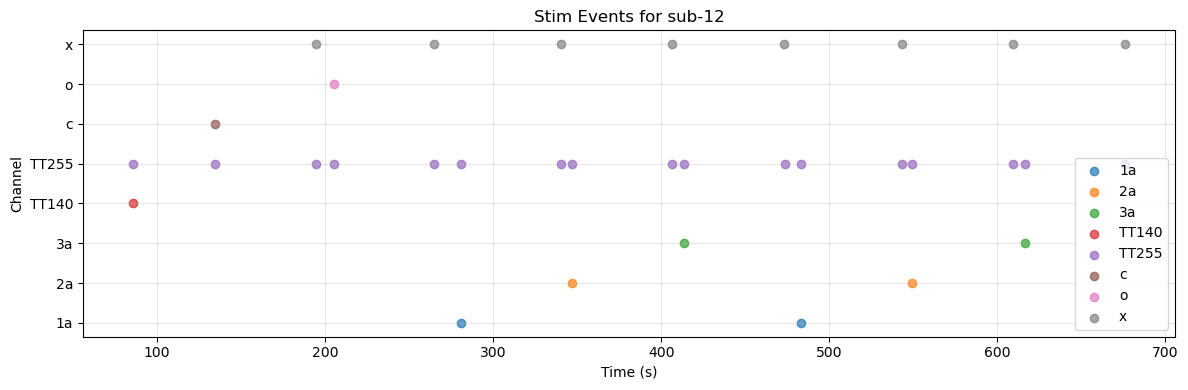

In [13]:
plot_stim_events('sub-12', all_events)

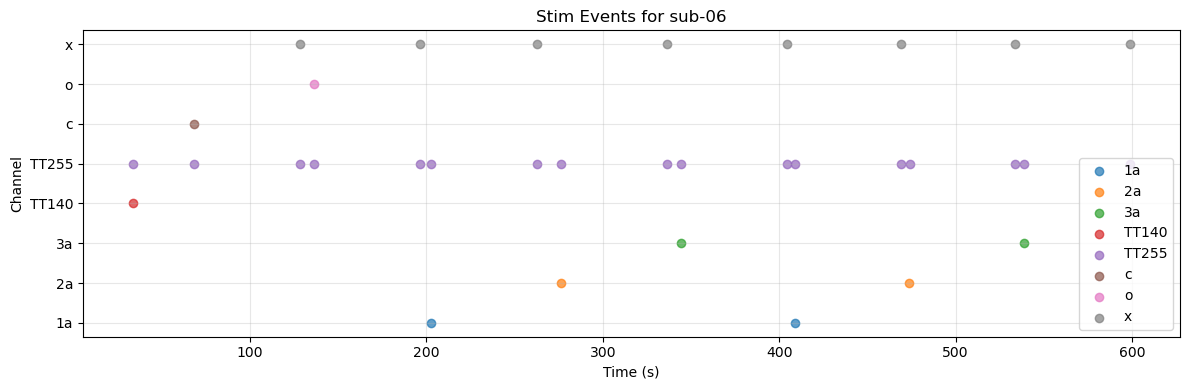

In [14]:
plot_stim_events('sub-06', all_events)

In [32]:
# Generate Trials
trials = get_trials_from_events(all_events)

# Save to CSV (optional)
trials.to_csv("rest_trials.csv", index=False)


In [33]:
# View sub-00
trials[trials['subject'] == 'sub-01']

,subject,trial_number,start_time,end_time,duration_s,trial_name
0,sub-01,1,132.838,192.840,60.002,c
1,sub-01,2,209.400,269.404,60.004,o
2,sub-01,3,301.930,361.932,60.002,l
3,sub-01,4,374.018,434.020,60.002,r
